In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
import time

In [2]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device
device=set_device()

In [3]:
batch_size = 64

In [4]:
path = "../Datasets/dataset_20_classes"
dataset = datasets.ImageFolder(root=path,transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset = dataset,batch_size=batch_size,shuffle=False)

In [5]:
root=pathlib.Path(path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['.DS_Store', 'Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


In [6]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [7]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    return data_set

In [8]:
dataset = transform(path)

In [9]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=False, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
print(str(train_size)+" "+str(val_size)+" "+str(test_size))

13803 1971 3945


In [10]:
model = models.mobilenet_v2(pretrained=False)

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
num_classes = 20 
model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes)

In [12]:
saved_state_dict = torch.load('Models_backup/2-Class-Mobilenetv2-50-epoch.pt', map_location=device)
new_state_dict = model.state_dict()

In [14]:
saved_weight = saved_state_dict['classifier.1.weight']
saved_bias = saved_state_dict['classifier.1.bias']
new_weight = new_state_dict['classifier.1.weight']
new_bias = new_state_dict['classifier.1.bias']
new_weight[:2] = saved_weight
new_bias[:2] = saved_bias

In [15]:
new_state_dict['classifier.1.weight'] = new_weight
new_state_dict['classifier.1.bias'] = new_bias

In [16]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
num_epochs=50
batch_size = batch_size
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [19]:
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
validation_accuracy = 0

In [21]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [22]:
for epoch in range(num_epochs):
    print("Epoch: %d "%(epoch+1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    t1 = time.time()
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in val_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    print("######## epoch Finished in {} seconds ###########".format(time.time()\
                                                                    -t1))
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f, Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
    
        

Epoch: 1 
######## epoch Finished in 193.0867099761963 seconds ###########
Training Data: Epoch Loss: 2.341, Epoch Accuracy: 33.116, Validation Loss: 2.010, Validation Accuracy: 37.849
Epoch: 2 
######## epoch Finished in 355.1242370605469 seconds ###########
Training Data: Epoch Loss: 1.713, Epoch Accuracy: 45.852, Validation Loss: 1.449, Validation Accuracy: 52.511
Epoch: 3 
######## epoch Finished in 2494.4143300056458 seconds ###########
Training Data: Epoch Loss: 1.273, Epoch Accuracy: 58.973, Validation Loss: 1.154, Validation Accuracy: 63.825
Epoch: 4 
######## epoch Finished in 1856.15092587471 seconds ###########
Training Data: Epoch Loss: 0.963, Epoch Accuracy: 68.420, Validation Loss: 0.828, Validation Accuracy: 73.871
Epoch: 5 
######## epoch Finished in 1151.4656829833984 seconds ###########
Training Data: Epoch Loss: 0.732, Epoch Accuracy: 76.309, Validation Loss: 0.617, Validation Accuracy: 80.619
Epoch: 6 
######## epoch Finished in 148.84732699394226 seconds ##########

######## epoch Finished in 148.3870391845703 seconds ###########
Training Data: Epoch Loss: 0.054, Epoch Accuracy: 98.305, Validation Loss: 0.079, Validation Accuracy: 97.159
Epoch: 46 
######## epoch Finished in 148.16532492637634 seconds ###########
Training Data: Epoch Loss: 0.054, Epoch Accuracy: 98.363, Validation Loss: 0.082, Validation Accuracy: 97.565
Epoch: 47 
######## epoch Finished in 147.28435897827148 seconds ###########
Training Data: Epoch Loss: 0.048, Epoch Accuracy: 98.537, Validation Loss: 0.092, Validation Accuracy: 96.804
Epoch: 48 
######## epoch Finished in 148.59959411621094 seconds ###########
Training Data: Epoch Loss: 0.040, Epoch Accuracy: 98.783, Validation Loss: 0.061, Validation Accuracy: 98.123
Epoch: 49 
######## epoch Finished in 147.10809898376465 seconds ###########
Training Data: Epoch Loss: 0.041, Epoch Accuracy: 98.768, Validation Loss: 0.069, Validation Accuracy: 97.869
Epoch: 50 
######## epoch Finished in 148.33523297309875 seconds ###########


In [23]:
epoch_count+=num_epochs
torch.save(model.state_dict(), "20-Class-MobileNetv2-TL-DeepTunning"+str(epoch_count)+"-epoch.pt")

In [24]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [25]:
evaluate_model(model,test_loader)

Testing Data: Epoch Accuracy: 98.530


98.5297845373891

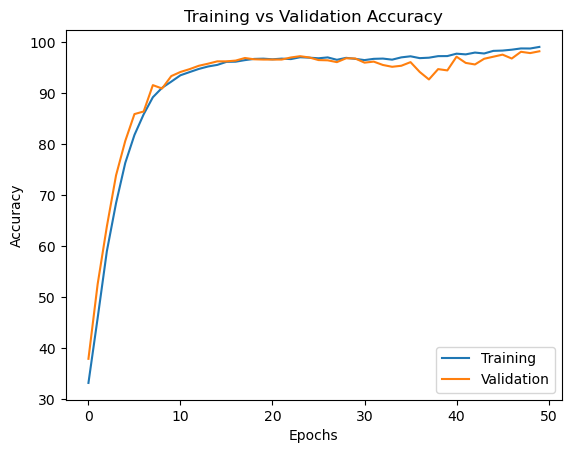

In [26]:
plt.plot(range(num_epochs),Accuracies,label="Training")
plt.plot(range(num_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

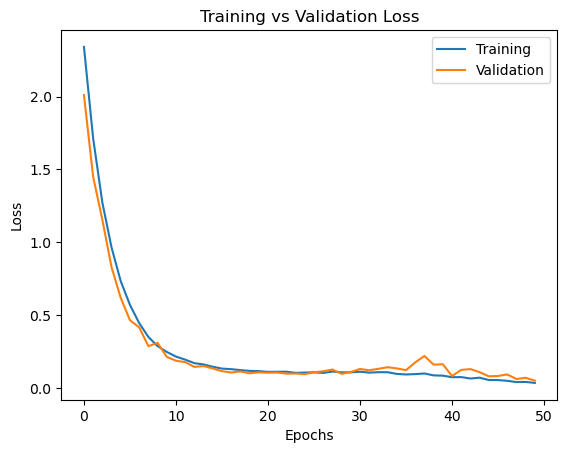

In [27]:
plt.plot(range(num_epochs),trainLoss,label="Training")
plt.plot(range(num_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [28]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

In [29]:
classes=classes[1:]

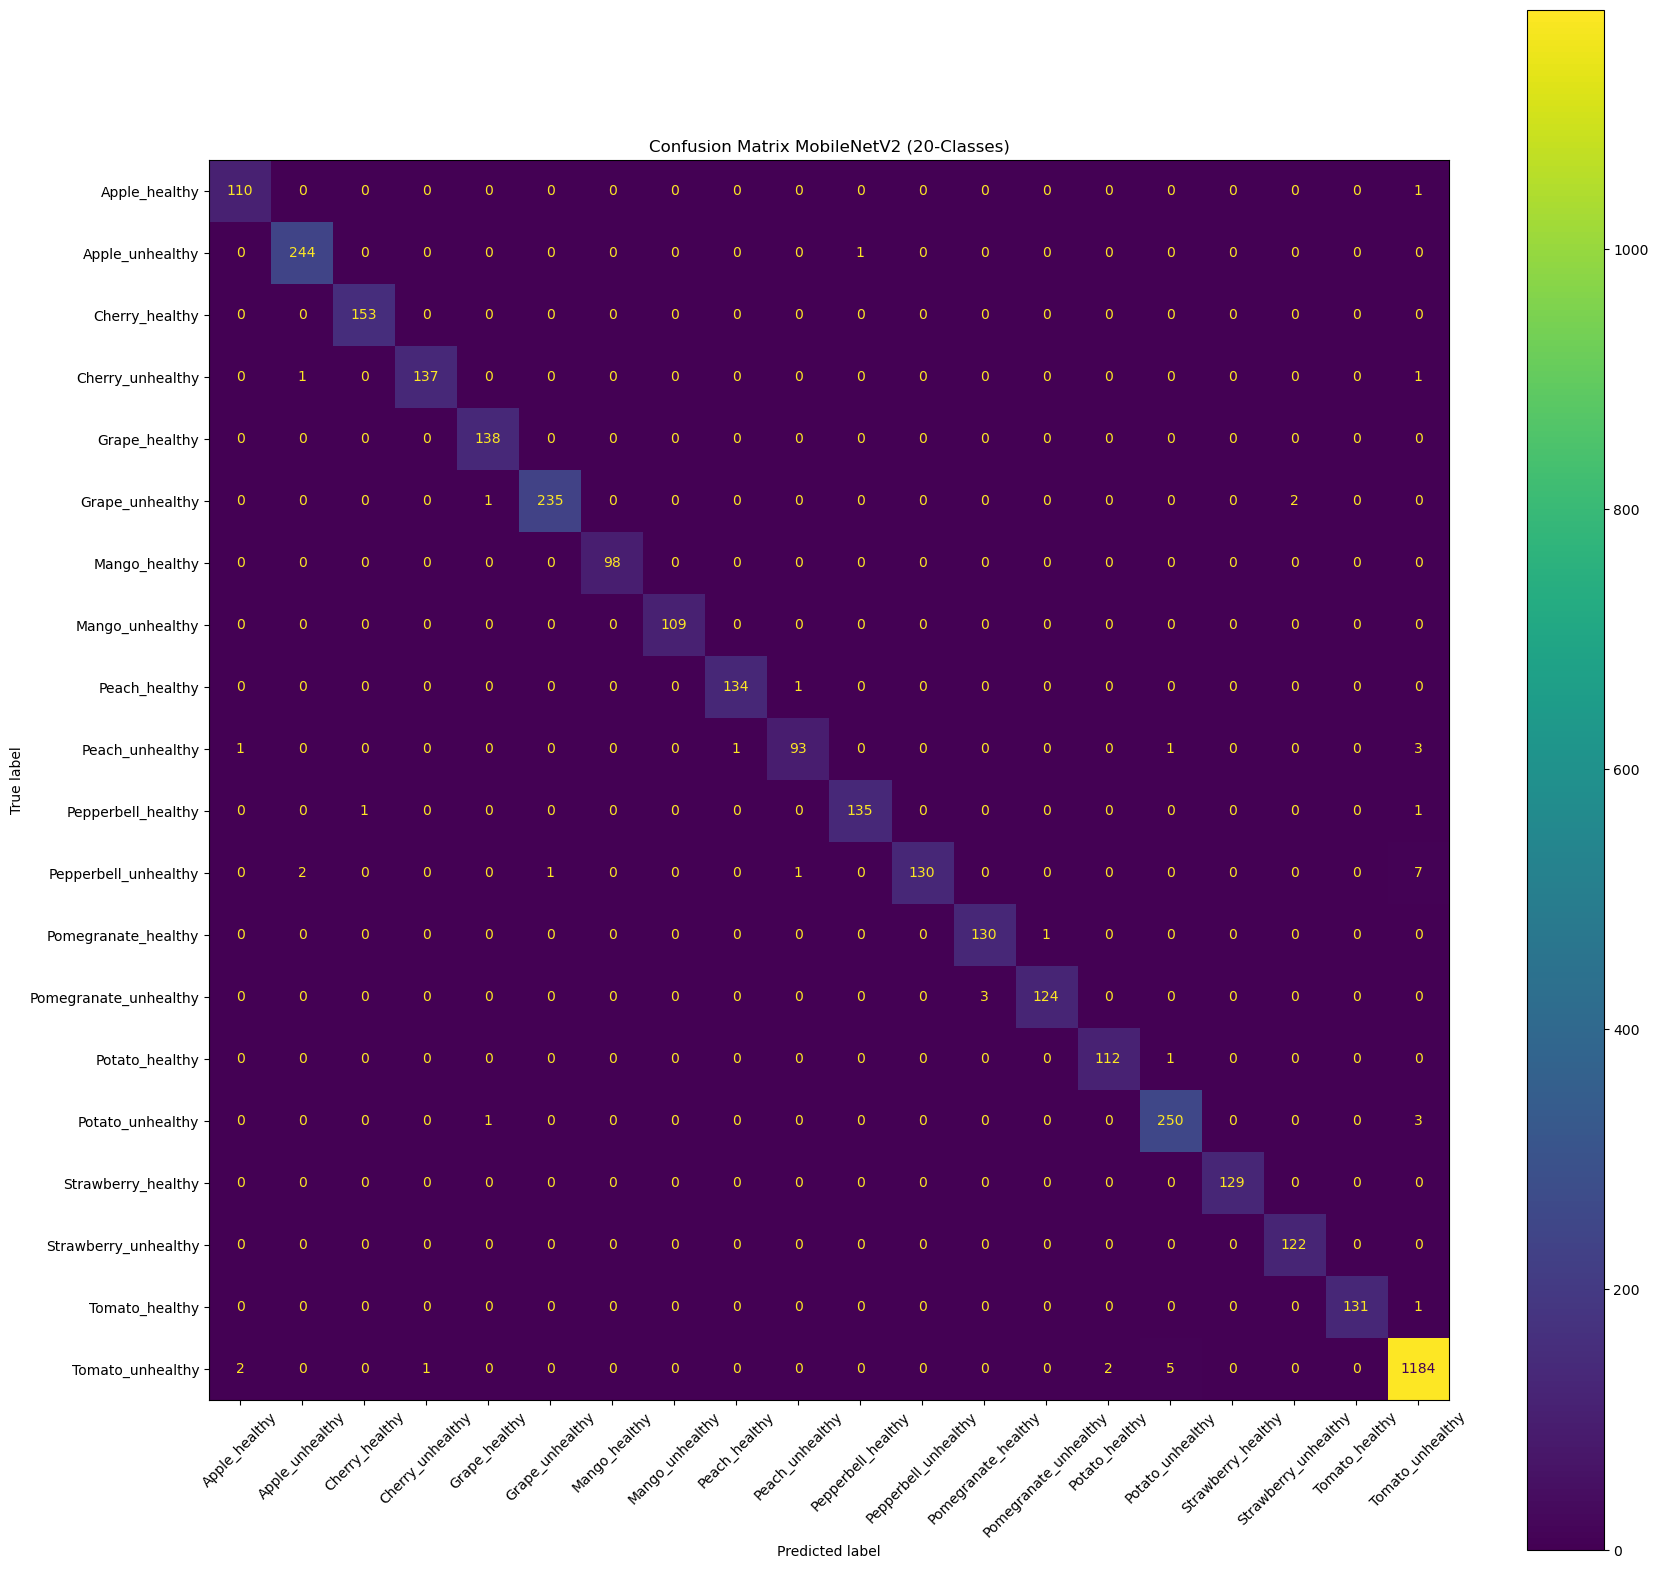

In [30]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
plt.title("Confusion Matrix MobileNetV2 (20-Classes)")
disp.plot(ax=ax,xticks_rotation=45)
plt.show()

In [31]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.99
Precision Micro:0.99
Recall Macro:0.99
Recall Micro:0.99
F1-Score Macro:0.99
F1-Score Micro:0.99
